## Imports

In [296]:
import pandas as pd
import requests
from urllib.request import Request, urlopen    
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from datetime import datetime
import math
import matplotlib.pyplot  as plt



# Acquisition

### Helper functions

In [297]:
#A function that returns a dataframe of all the historic data of a given ticker. 
def get_yfinance_data(ticker):
	url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=994016928&period2=1642982400&interval=1d&events=history&includeAdjustedClose=true'

	data = pd.read_csv(url)

	return data

### Retrieval

In [298]:
#Get crypto historic prices
df_btc_usd = get_yfinance_data('BTC-USD')
df_eth_usd = get_yfinance_data('ETH-USD')
df_sol_usd = get_yfinance_data('SOL1-USD')
df_ada_usd = get_yfinance_data('ADA-USD')
df_doge_usd = get_yfinance_data('DOGE-USD')
df_xrp_usd = get_yfinance_data('XRP-USD')


In [299]:
crypto_dfs = [df_sol_usd, df_ada_usd, df_doge_usd, df_eth_usd, df_xrp_usd]

# Preprocessing

### Helper functions

In [300]:
#Function that returns the oldest data from a list of data frames. 
def str_to_datetime(dataframes, date_column):
	for df in dataframes:
		df[date_column] = pd.to_datetime(df[date_column]).dt.date

#Function that returns the first date of the "youngest" of dataframes
def get_min_possible_date(dataframes, date_column):

	return max([min(dataframe[date_column]) for dataframe in dataframes])


#DONT USE, Function that returns the oldest date along with the name of the df that contains it
def get_oldest_df(dataframes, date_column):
	ol_date = (get_min_possible_date(dataframes, date_column), 42)
	for i, df in enumerate(dataframes):
		first_entry = min(df[date_column])
		if first_entry < ol_date[0]:
			ol_date = (first_entry, i)
	
	return ol_date[0], dataframes[ol_date[1]]

### Crypto Index

In [301]:
#Turn Date columns from str to datetime format
# str_to_datetime(crypto_dfs, 'Date')

We know that bitcoin is the oldest cryptocurrency so we can calculate the index with it as a base

In [302]:
#Clean data to just the variables we need
df_btc_usd = df_btc_usd[['Date', 'Close', 'Volume']].rename({'Close': 'BTC_price', 'Volume': 'BTC_vol'}, axis=1)
df_eth_usd = df_eth_usd[['Date', 'Close', 'Volume']].rename({'Close': 'ETH_price', 'Volume': 'ETH_vol'}, axis=1)
df_sol_usd = df_sol_usd[['Date', 'Close', 'Volume']].rename({'Close': 'SOL_price', 'Volume': 'SOL_vol'}, axis=1)
df_ada_usd = df_ada_usd[['Date', 'Close', 'Volume']].rename({'Close': 'ADA_price', 'Volume': 'ADA_vol'}, axis=1)
df_doge_usd = df_doge_usd[['Date', 'Close', 'Volume']].rename({'Close': 'DOGE_price', 'Volume': 'DOGE_vol'}, axis=1)
df_xrp_usd = df_xrp_usd[['Date', 'Close', 'Volume']].rename({'Close': 'XRP_price', 'Volume': 'XRP_vol'}, axis=1)


In [303]:
#Create new Dataframe inlcuding all cryptocurrencies closing prices and volumes
cr_index = df_btc_usd
cr_index = cr_index.merge(df_eth_usd, on='Date', how='left')
cr_index = cr_index.merge(df_ada_usd, on='Date', how='left')
cr_index = cr_index.merge(df_xrp_usd, on='Date', how='left')
cr_index = cr_index.merge(df_doge_usd, on='Date', how='left')
cr_index = cr_index.merge(df_sol_usd, on='Date', how='left')

In [304]:
cr_index

,Date,BTC_price,BTC_vol,ETH_price,ETH_vol,ADA_price,ADA_vol,XRP_price,XRP_vol,DOGE_price,DOGE_vol,SOL_price,SOL_vol
0,2014-09-17,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,424.440002,34483200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,394.795990,37919700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2682,2022-01-20,40680.417969,20382033940,3001.120117,1.064592e+10,1.258055,1.686210e+09,0.719421,1.251475e+09,0.155204,4.692697e+08,0.822658,50.0
2683,2022-01-21,36457.316406,43011992031,2557.931641,2.679629e+10,1.123233,3.009628e+09,0.635738,3.150759e+09,0.142640,1.163062e+09,0.770828,238.0
2684,2022-01-22,35030.250000,39714385405,2405.181152,2.736969e+10,1.066716,3.930475e+09,0.596042,3.613862e+09,0.132892,1.693525e+09,0.759746,319.0
2685,2022-01-23,36276.804688,26017975951,2535.039063,1.648149e+10,1.122371,2.362627e+09,0.628756,1.851935e+09,0.141863,1.006235e+09,0.777831,227.0


In [305]:
#Turn "Date" column to datetime format instead of str
str_to_datetime([cr_index], 'Date')

#Fill NaNs with 0
cr_index = cr_index.fillna(0)

#Calculate total trading volume per day
cr_index['tot_volume'] = cr_index[['BTC_vol', 'ETH_vol', 'ADA_vol', 'XRP_vol', 'DOGE_vol', 'SOL_vol']].sum(axis=1)

In [306]:
cr_index.columns

Index(['Date', 'BTC_price', 'BTC_vol', 'ETH_price', 'ETH_vol', 'ADA_price',
       'ADA_vol', 'XRP_price', 'XRP_vol', 'DOGE_price', 'DOGE_vol',
       'SOL_price', 'SOL_vol', 'tot_volume'],
      dtype='object')

In [307]:

def index_calc(df):

	return math.log(sum([(df['BTC_price']*(df['BTC_vol']/df['tot_volume'])),
			  (df['ETH_price']*(df['ETH_vol']/df['tot_volume'])),
			  (df['ADA_price']*(df['ADA_vol']/df['tot_volume'])),
			  (df['XRP_price']*(df['XRP_vol']/df['tot_volume'])),
			  (df['DOGE_price']*(df['DOGE_vol']/df['tot_volume'])),
			  (df['SOL_price']*(df['SOL_vol']/df['tot_volume']))]))

cr_index['Crypto_Index'] = cr_index.apply(index_calc, axis=1)

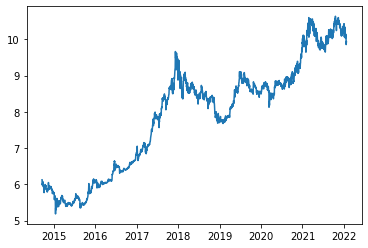

In [308]:
plt.plot(cr_index['Date'], cr_index['Crypto_Index'])
